In [13]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
main_dir = './CVDATASET'
train_dataset_dir = main_dir + "/train"
test_dataset_dir = main_dir + "/test"

In [3]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Define image dimensions and batch size
img_height = 32
img_width = 32
batch_size = 64

# Load the training data
train_ds_full = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Split train into train and validation
train_size = int(0.8 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds = train_ds_full.take(train_size)
val_ds = train_ds_full.skip(train_size)

# Load the test data
val_ds_test = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Training Classes:")
class_names = train_ds_full.class_names
print(class_names)

print("Testing Classes:")
print(val_ds_test.class_names)

Found 100000 files belonging to 2 classes.


2025-03-15 09:55:07.704506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 866 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:09.0, compute capability: 8.0
2025-03-15 09:55:07.912018: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [5]:
num_classes = 2

In [6]:
# Load Pre-trained EfficientNetV2S Model
EffNetV2_base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the bottom block (e.g., last 20 layers)
for layer in EffNetV2_base_model.layers[-20:]:
    layer.trainable = True

# Add classification head
x = GlobalAveragePooling2D()(EffNetV2_base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=EffNetV2_base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [8]:
# Train the model
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=10, 
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/10


2025-03-15 09:55:53.758934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-15 09:55:58.441263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-03-15 09:55:58.514542: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-15 09:55:59.851565: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe3e0050260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-15 09:55:59.851608: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-15 09:55:59.860781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, s

1250/1250 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8167

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 247s 126ms/step - loss: 0.4139 - accuracy: 0.8167 - val_loss: 0.1962 - val_accuracy: 0.9194 - lr: 1.0000e-04
Epoch 2/10
1250/1250 [==============================] - 154s 123ms/step - loss: 0.1928 - accuracy: 0.9246 - val_loss: 0.1349 - val_accuracy: 0.9472 - lr: 1.0000e-04
Epoch 3/10
1250/1250 [==============================] - 155s 124ms/step - loss: 0.1375 - accuracy: 0.9478 - val_loss: 0.1047 - val_accuracy: 0.9609 - lr: 1.0000e-04
Epoch 4/10
1250/1250 [==============================] - 152s 122ms/step - loss: 0.0992 - accuracy: 0.9625 - val_loss: 0.0943 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 5/10
1250/1250 [==============================] - 154s 123ms/step - loss: 0.0720 - accuracy: 0.9727 - val_loss: 0.0900 - val_accuracy: 0.9687 - lr: 1.0000e-04
Epoch 6/10
 987/1250 [======================>.......] - ETA: 28s - loss: 0.0530 - accuracy: 0.9810

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1250/1250 [==============================] - 158s 127ms/step - loss: 0.0303 - accuracy: 0.9892 - val_loss: 0.0847 - val_accuracy: 0.9724 - lr: 1.0000e-04
Epoch 9/10
1250/1250 [==============================] - 153s 122ms/step - loss: 0.0225 - accuracy: 0.9918 - val_loss: 0.0890 - val_accuracy: 0.9723 - lr: 1.0000e-04
Epoch 10/10
1250/1250 [==============================] - 158s 126ms/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.1048 - val_accuracy: 0.9729 - lr: 1.0000e-04


In [9]:
# Evaluate the model
y_true = []
y_pred = []
y_scores = []

for images, labels in val_ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_scores.extend(preds[:, 1])  # Assuming binary classification

1/1 [==============================] - 0s 51ms/step


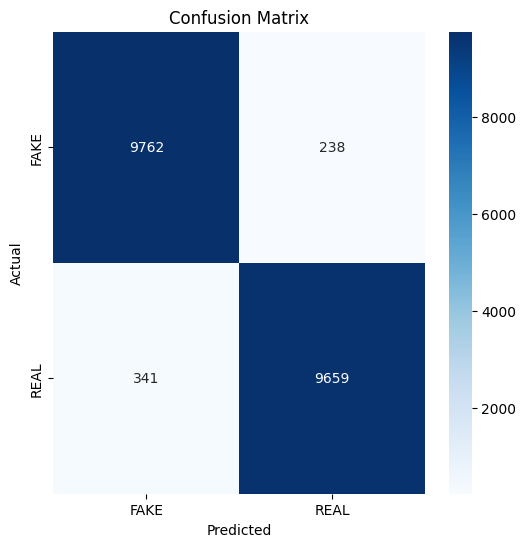

In [14]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Compute classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.97      0.98      0.97     10000
        REAL       0.98      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



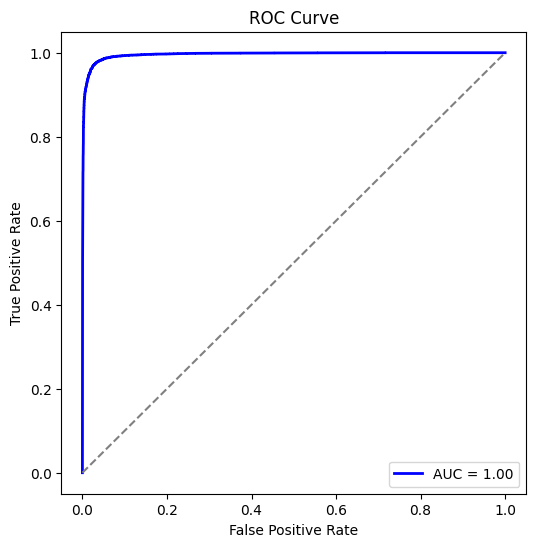

In [16]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
# Print metrics
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {roc_auc:.4f}")

Accuracy: 0.9710
AUC: 0.9957


In [18]:
model.save('Pure_EfficientNet.h5')
model.save('Pure_EfficientNet.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
